## Implementing Neural Networks from Scratch

In [2]:
import numpy as np
import pandas as pd

# this library can make datasets for you
from sklearn.datasets import make_classification
X,Y = make_classification(n_samples = 1000, n_features=5,random_state=42)

In [3]:
X = X.T

In [4]:
Y.shape

(1000,)

In [5]:
Y = np.array(Y).reshape(1,-1)

In [7]:
Y.shape

(1, 1000)

In [36]:
nn_arch = [
    {'layer_units':5, 'activation':'none'}, #for the input layer
    {'layer_units':5, 'activation':'relu'}, #inner layer: Relu is preferred
    {'layer_units':4, 'activation':'relu'}, #
    {'layer_units':3, 'activation':'relu'}, #
    {'layer_units':1, 'activation':'sigmoid'} #
]

In [52]:
# number of layers will be equal to the number of weights and bias
def initialised_parameters(nn_arch,seed_value):
    #  seed_value=any non-zero number, for the same initialisation
    np.random.seed(seed_value)
    number_of_layers = len(nn_arch)
    parameters = {}     #to store weights and bias of each layer
    for l in range(1, number_of_layers):
        parameters['W'+str(l)] = np.random.randn(
            nn_arch[l]['layer_units'],
            nn_arch[l-1]['layer_units'],
        )*0.001
        parameters['b'+str(l)] = np.zeros((nn_arch[l]['layer_units'],1))
    return parameters


In [53]:
parameters = initialised_parameters(nn_arch, 3)
print(parameters)

{'W1': array([[ 1.78862847e-03,  4.36509851e-04,  9.64974681e-05,
        -1.86349270e-03, -2.77388203e-04],
       [-3.54758979e-04, -8.27414815e-05, -6.27000677e-04,
        -4.38181690e-05, -4.77218030e-04],
       [-1.31386475e-03,  8.84622380e-04,  8.81318042e-04,
         1.70957306e-03,  5.00336422e-05],
       [-4.04677415e-04, -5.45359948e-04, -1.54647732e-03,
         9.82367434e-04, -1.10106763e-03],
       [-1.18504653e-03, -2.05649899e-04,  1.48614836e-03,
         2.36716267e-04, -1.02378514e-03]]), 'b1': array([[0.],
       [0.],
       [0.],
       [0.],
       [0.]]), 'W2': array([[-0.00071299,  0.00062524, -0.00016051, -0.00076884, -0.00023003],
       [ 0.00074506,  0.00197611, -0.00124412, -0.00062642, -0.00080377],
       [-0.00241908, -0.00092379, -0.00102388,  0.00112398, -0.00013191],
       [-0.00162329,  0.00064668, -0.00035627, -0.00174314, -0.00059665]]), 'b2': array([[0.],
       [0.],
       [0.],
       [0.]]), 'W3': array([[-5.88594380e-04, -8.73882298e-

In [54]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

In [55]:
def relu(z):
    return np.maximum(0,z)

In [56]:
# # activation of the first layer is the feature matrix
# def forward_propogation(nn_arch, parameters, X):
#     forward_cache = {}
#     number_of_layers = len(nn_arch)
#     A_prev = X          #previous layer's activation
#     for l in range(1, number_of_layers):
#         W=parameters['W'+str(l)]        #weight for the lth layer
#         b = parameters['b'+str(l)]
#         activation = nn_arch[l]['activation']
#         if activation=='relu':
#             forward_cache['Z'+str(l)] = np.dot(W, A_prev)+b
#             forward_cache['A'+str(l)] = relu(forward_cache['Z'+str(l)])
#         elif activation=='sigmoid':
#             forward_cache['Z'+str(l)] = np.dot(W, A_prev)+b
#             forward_cache['A'+str(l)] = sigmoid(forward_cache['Z'+str(l)])
#         AL = forward_cache['A'+str(l)]
#         forward_cache['A0']=X
#     return AL, forward_cache

# # if the number of activation energies increase, just add them as if-elif cases
    
#     # AL = Activation of last layer, used for cost computation
        


In [57]:
def forward_propogation(nn_arch, parameters, X):
#activation of 0th layer is the input matrix X
#need z and activation of each layer ==> save in a dict
    forward_cache = {}
    no_of_layers = len(nn_arch)
    #need to initialize A0
    # to find z and activation of each layer we need activation of prev layer
    A_prev = X
    for l in range(1, no_of_layers):
        W=parameters['W'+str(l)] #weight for lth layer
        b = parameters['b'+str(l)]
        activation = nn_arch[l]['activation']
        if activation == "relu":
            #find Z and A
            Z = np.dot(W,A_prev)+b
            forward_cache['Z'+str(l)] = Z
            forward_cache['A'+str(l)] = relu(Z)
        elif activation == "sigmoid":
            Z = np.dot(W,A_prev)+b
            forward_cache['Z'+str(l)] = Z
            forward_cache['A'+str(l)] = sigmoid(Z)
        A_prev = forward_cache['A'+str(l)]
    #activation of last layer => used for cost computation
    AL = forward_cache['A'+str(l)]
    forward_cache['A0'] = X
    #while updating gradient of weight matrix dw=dz A(l-1)
    return AL,forward_cache

In [58]:
AL, forward_cache = forward_propogation(nn_arch, parameters, X)

In [59]:
def compute_cost(AL, Y):
    n=Y.shape[1]
    cost = (-1/n)*np.sum((Y*np.log(AL))+((1-Y)*np.log(1-AL)))
    return np.squeeze(cost)     #to return a value and squeezing it's axes


In [60]:
cost = compute_cost(AL, Y)
print(cost)

0.6931471805615643


In [61]:
def sigmoid_backward(dA,Z):
    S = sigmoid(Z)
    dS = S*(1-S)
    return dA*dS

In [62]:
def relu_backward(dA,Z):
    # S = sigmoid(Z)
    dZ = np.array(dA,copy=True)
    dZ[dZ>0]=1
    dZ[dZ<=0]=0
    return dA*dZ

In [65]:
def back_propogation(Y,AL,nn_arch,parameters,forward_cache):
    grads = {}
    number_of_layers = len(nn_arch)
    dAL=(AL-Y)/(AL*(1-AL))
    dA_prev = dAL
    n=Y.shape[1]

    # n is the number of examples
    # L is for the number of layers
    # k is the number of features
    for l in reversed(range(1,number_of_layers)):
        Z_curr = forward_cache['Z'+str(l)]
        W_curr = parameters['W'+str(l)]
        A_prev = forward_cache['A'+str(l-1)]       # this is needed of the previous entry
        activation = nn_arch[l]['activation']

        if activation=='sigmoid':
            dZl = sigmoid_backward(dA_prev, Z_curr)
            grads['dW'+str(l)]=(1/n)*np.dot(dZl,A_prev.T)     #gradient's dictionary
            grads['db'+str(l)]=(1/n)*np.sum(dZl,axis=1,keepdims=True)
            dA_prev = np.dot(W_curr.T,dZl)
        
        elif activation=='relu':
            dZl = relu_backward(dA_prev, Z_curr)
            grads['dW'+str(l)]=(1/n)*np.dot(dZl,A_prev.T)     #gradient's dictionary
            grads['db'+str(l)]=(1/n)*np.sum(dZl,axis=1,keepdims=True)
            dA_prev = np.dot(W_curr.T,dZl)

    return grads



In [66]:
grads = back_propogation(Y,AL,nn_arch,parameters,forward_cache)

In [67]:
def update_parameters(grads,parameters,lr, nn_arch):
    number_of_layers = len(nn_arch)
    for l in range(1, number_of_layers):
        parameters['W'+str(l)] = parameters['W'+str(l)]-lr*grads['dW'+str(l)]
        parameters['b'+str(l)] = parameters['b'+str(l)]-lr*grads['db'+str(l)]
    return parameters

In [68]:
#all topgether in one prgm to train

def training_phase(nn_arch,X,Y,lr,iterations):      #learning rate(lr)
    parameters = initialised_parameters(nn_arch,3)
    costs=[]
    for i in range(iterations):
        AL, forward_cache = forward_propogation(nn_arch,parameters,X)
        cost = compute_cost(AL,Y)

        if(i%100 == 0):
            costs.append(cost)
            print('Iteration: '+str(i)+' Cost:'+str(cost))
        grads = back_propogation(Y,AL,nn_arch,parameters,forward_cache)
        parameters = update_parameters(grads,parameters,lr, nn_arch)

    return costs, parameters

In [72]:
costs, parameters = training_phase(nn_arch, X, Y, 0.01,3000)

Iteration: 0 Cost:0.6931471805615643
Iteration: 100 Cost:0.6931471805599454
Iteration: 200 Cost:0.6931471805599454
Iteration: 300 Cost:0.6931471805599453
Iteration: 400 Cost:0.6931471805599454
Iteration: 500 Cost:0.6931471805599452
Iteration: 600 Cost:0.6931471805599454
Iteration: 700 Cost:0.6931471805599452
Iteration: 800 Cost:0.6931471805599454
Iteration: 900 Cost:0.6931471805599452
Iteration: 1000 Cost:0.6931471805599452
Iteration: 1100 Cost:0.6931471805599454
Iteration: 1200 Cost:0.6931471805599454
Iteration: 1300 Cost:0.6931471805599454
Iteration: 1400 Cost:0.6931471805599454
Iteration: 1500 Cost:0.6931471805599454
Iteration: 1600 Cost:0.6931471805599454
Iteration: 1700 Cost:0.6931471805599454
Iteration: 1800 Cost:0.6931471805599454
Iteration: 1900 Cost:0.6931471805599454
Iteration: 2000 Cost:0.6931471805599454
Iteration: 2100 Cost:0.6931471805599454
Iteration: 2200 Cost:0.6931471805599454
Iteration: 2300 Cost:0.6931471805599454
Iteration: 2400 Cost:0.6931471805599454
Iteration: 2

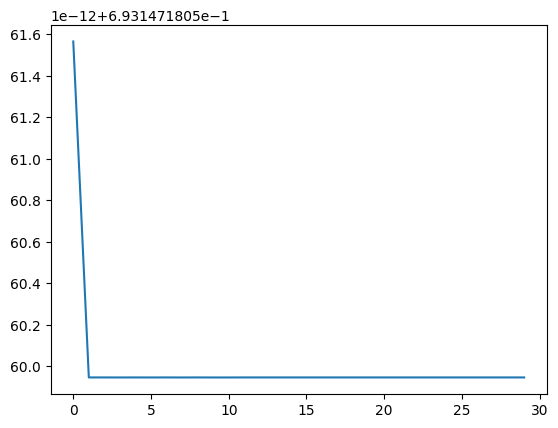

In [73]:
import matplotlib.pyplot as plt
plt.plot(costs)